In [296]:
import numpy as np
import scipy.stats as sts
import scipy.special as spec
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integral
import pandas as pd
import statsmodels.api as sm
import numpy.linalg as lin
%matplotlib notebook

In [297]:
#input data
dt = pd.read_excel('data.xlsx')
T = 500
S = 10
#sigma_y = 0.4
#sigma_pi= 1
#sigma_i = 0.3
#alpha_pi = 1
#gamma = 0

# Stochastic Version

#### In this case, we have three random shocks in our model, and we will aplly simulated method of moment

In [298]:
#Generate three shocks
unif_vals_1 = sts.uniform.rvs(0, 1, size=(T, S))
unif_vals_2 = sts.uniform.rvs(0, 1, size=(T, S))
unif_vals_3 = sts.uniform.rvs(0, 1, size=(T, S))

In [299]:
#Generate a Matrix from uniform distribution.
def norm_draws(unif_vals, sigma):
    norm_draws = sts.norm.ppf(unif_vals, loc=0, scale=sigma)
    
    return norm_draws

In [300]:
#defined model function to simulate model data
def model(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i):
    
    interest_rate_lag = 3.99*np.ones(S)
    b = np.zeros((T, S))
    pi_c = np.zeros((T, S))
    interest_rate = np.zeros((T, S))
    pi = np.zeros((T, S))
    y = np.zeros((T, S))
    
    probnp = np.zeros(S)
    probpn = np.zeros(S)
    
    b[0,:] = 0.5*np.ones(S)
    pi_c[0,:] = 2.23*np.ones(S)
    
    Shock_y = norm_draws(unif_vals_1, sigma_y)
    Shock_pi = norm_draws(unif_vals_2, sigma_pi)
    Shock_i = norm_draws(unif_vals_3, sigma_i)
    
    for i in range(T):
        y[i,:] = eta * b[i,:] + Shock_y[i,:]
        pi[i,:] = pi_c[i,:] + kappa * y[i,:] + Shock_pi[i,:]
        interest_rate[i,:] = mu_i * interest_rate_lag + (1-mu_i) * (5 + mu_pi * (pi[i,:] - 2.5) + mu_y * y[i,:])\
                             + Shock_i[i,:]
        
        if i < T-1:
            pi_c[i+1,:] = pi_c[i,:] + alpha_pi * (gamma*2.5 + (1-gamma) * pi[i,:] - pi_c[i,:])
            
            f = sai_b*b[i,:] - sai_i*(interest_rate[i,:] - pi[i,:] - 2.5)
            for j in range(S):
                probnp[j] = min(1, 0.125*np.exp(f[j]))
                probpn[j] = min(1, 0.125*np.exp(-f[j]))
            
            b[i+1,:] = b[i,:] + np.multiply((1-b[i,:]), probnp) - np.multiply((1+b[i,:]), probpn)
            
        interest_rate_lag = interest_rate[i,:]
        
    return y[200:,:], pi[200:,:], interest_rate[200:,:]
    #return y, pi, interest_rate

In [301]:
#use simulated model data to compute model moment
def model_moment(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i):
    y_mod, pi_mod, ir_mod = model(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i)
    
    covYY_m = np.zeros(9)
    covII_m = np.zeros(9)
    covPP_m = np.zeros(9)
    covYI_m = np.zeros(9)
    covYP_m = np.zeros(9)
    covIP_m = np.zeros(9)
    covIY_m = np.zeros(8)
    covPY_m = np.zeros(8)
    covPI_m = np.zeros(8)
    
    covYY_mod = np.zeros((9, S))
    covII_mod = np.zeros((9, S))
    covPP_mod = np.zeros((9, S))
    covYI_mod = np.zeros((9, S))
    covYP_mod = np.zeros((9, S))
    covIP_mod = np.zeros((9, S))
    covIY_mod = np.zeros((8, S))
    covPY_mod = np.zeros((8, S))
    covPI_mod = np.zeros((8, S))
    
    for j in range(S):
        for i in range(9):
            covYY_mod[i,j] = np.cov(y_mod[i:T-200,j], y_mod[:T-200-i,j])[0][1]
    
        for i in range(9):
            covII_mod[i,j] = np.cov(ir_mod[i:T-200,j], ir_mod[:T-200-i,j])[0][1]
    
        for i in range(9):
            covPP_mod[i,j] = np.cov(pi_mod[i:T-200,j], pi_mod[:T-200-i,j])[0][1]

        for i in range(9):
            covYI_mod[i,j] = np.cov(y_mod[i:T-200,j], ir_mod[:T-200-i,j])[0][1]
    
        for i in range(9):
            covYP_mod[i,j] = np.cov(y_mod[i:T-200,j], pi_mod[:T-200-i,j])[0][1]
    
        for i in range(9):
            covIP_mod[i,j] = np.cov(ir_mod[i:T-200,j], pi_mod[:T-200-i,j])[0][1]
    
        for i in range(1,9):
            covIY_mod[i-1,j] = np.cov(ir_mod[i:T-200,j], y_mod[:T-200-i,j])[0][1]
    
        for i in range(1,9):
            covPY_mod[i-1,j] = np.cov(pi_mod[i:T-200,j], y_mod[:T-200-i,j])[0][1]
    
        for i in range(1,9):
            covPI_mod[i-1,j] = np.cov(pi_mod[i:T-200,j], ir_mod[:T-200-i,j])[0][1]
        
    
    for i in range(9):
        covYY_m[i] = covYY_mod[i,:].sum()/1000
        covII_m[i] = covII_mod[i,:].sum()/1000
        covPP_m[i] = covPP_mod[i,:].sum()/1000
        covYI_m[i] = covYI_mod[i,:].sum()/1000
        covYP_m[i] = covYP_mod[i,:].sum()/1000
        covIP_m[i] = covIP_mod[i,:].sum()/1000
        
    for i in range(8):
        covIY_m[i] = covIY_mod[i,:].sum()/1000
        covPY_m[i] = covPY_mod[i,:].sum()/1000
        covPI_m[i] = covPI_mod[i,:].sum()/1000
        
    return covYY_m, covII_m, covPP_m, covYI_m, covYP_m, covIP_m, covIY_m, covPY_m, covPI_m

In [302]:
#compute data moment
dt_y = dt['Output Gap'].values
dt_p = dt.Inflation.values
dt_i = dt['interest rate'].values

covYY = np.zeros(9)
covII = np.zeros(9)
covPP = np.zeros(9)
covYI = np.zeros(9)
covYP = np.zeros(9)
covIP = np.zeros(9)
covIY = np.zeros(8)
covPY = np.zeros(8)
covPI = np.zeros(8)


for i in range(9):
    covYY[i] = np.cov(dt_y[i:78], dt_y[:78-i])[0][1]
    
for i in range(9):
    covII[i] = np.cov(dt_i[i:78], dt_i[:78-i])[0][1]
    
for i in range(9):
    covPP[i] = np.cov(dt_p[i:78], dt_p[:78-i])[0][1]

for i in range(9):
    covYI[i] = np.cov(dt_y[i:78], dt_i[:78-i])[0][1]
    
for i in range(9):
    covYP[i] = np.cov(dt_y[i:78], dt_p[:78-i])[0][1]
    
for i in range(9):
    covIP[i] = np.cov(dt_i[i:78], dt_p[:78-i])[0][1]
    
for i in range(1,9):
    covIY[i-1] = np.cov(dt_i[i:78], dt_y[:78-i])[0][1]
    
for i in range(1,9):
    covPY[i-1] = np.cov(dt_p[i:78], dt_y[:78-i])[0][1]
    
for i in range(1,9):
    covPI[i-1] = np.cov(dt_p[i:78], dt_i[:78-i])[0][1]

In [303]:
#Compute the error vector
def err_vec(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i):
    covYY_m, covII_m, covPP_m, covYI_m, covYP_m, covIP_m, covIY_m, covPY_m, covPI_m = model_moment(sai_b, sai_i, eta,\
                                                kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i)
    err_vec = np.append(covYY_m-covYY, covII_m-covII)
    err_vec = np.append(err_vec, covPP_m - covPP)
    err_vec = np.append(err_vec, covYI_m - covYI)
    err_vec = np.append(err_vec, covYP_m - covYP)
    err_vec = np.append(err_vec, covIP_m - covIP)
    err_vec = np.append(err_vec, covIY_m - covIY)
    err_vec = np.append(err_vec, covPY_m - covPY)
    err_vec = np.append(err_vec, covPI_m - covPI)
    
    return err_vec

In [304]:
#Compute criterion function
def crit(params, *args):
    sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i = params
    W_hat = args
    
    err = err_vec(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i)
    
    crit_val = np.dot(np.dot(err.T, W_hat), err)
    
    return crit_val

In [305]:
# Since we want to use the Iterated variance covariance estimator, then we first estimate the
# parameters by using the Identity Matrix
W_Id = np.eye(78)
sai_b_init = 0.563
sai_i_init = 0.067
eta_init = 99
kappa_init = 0.245
alpha_pi_init = 1
gamma_init = 0
mu_i_init = 0
mu_pi_init = 1.208
mu_y_init = 0
sigma_y_init = 0.5
sigma_pi_init = 0.5
sigma_i_init = 0.5

params_init = np.array([sai_b_init, sai_i_init, eta_init, kappa_init, alpha_pi_init, gamma_init, mu_i_init, mu_pi_init, mu_y_init, sigma_y_init, sigma_pi_init, sigma_i_init])
W_hat = W_Id

results = opt.minimize(crit, params_init, args=(W_hat), method='L-BFGS-B',bounds=((0, 5), (1e-2, 15),(1e-2,None),\
                                                                                  (1e-2,1),(0,1),(0,1),(1e-2,1),\
                                                                                  (1e-2,4),(1e-2,5),(0,1),(0,1),(0,1)))

In [306]:
results

      fun: array([ 125.96956872])
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.44023113e-01,  -1.44186174e-01,  -1.90496507e-02,
        -1.15190772e+00,  -6.44838849e-01,   5.70184785e+03,
        -6.59008492e-01,   4.62128611e+00,   1.18057102e+00,
        -7.69517783e-03,   2.28201458e+00,   2.41910669e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5889
      nit: 298
   status: 0
  success: True
        x: array([  7.71869585e-01,   7.43643801e-01,   9.90006294e+01,
         2.57282692e-02,   9.99991061e-01,   0.00000000e+00,
         3.41543891e-01,   1.00005016e+00,   1.77720166e-02,
         5.21439738e-01,   9.17195889e-01,   2.43992048e-01])

In [309]:
Shock_y = norm_draws(unif_vals_1, sigma_y)
Shock_pi = norm_draws(unif_vals_2, sigma_pi)
Shock_i = norm_draws(unif_vals_3, sigma_i)

avg_shock_y = np.zeros(T)
avg_shock_pi = np.zeros(T)
avg_shock_i = np.zeros(T)


for i in range(T):
    avg_shock_y[i] = Shock_y[i,:].mean()
    avg_shock_pi[i] = Shock_pi[i,:].mean()
    avg_shock_i[i] = Shock_i[i,:].mean()

In [312]:
# After getting the average shock, we compute the model data

R = 500
def mod(sai_b, sai_i, eta, kappa, alpha_pi, gamma, mu_i, mu_pi, mu_y, sigma_y, sigma_pi, sigma_i):
    interest_rate_lag = 3.99
    b = np.zeros(R)
    pi_c = np.zeros(R)
    pi_c[0] = 2.23
    b[0] = 0
    
    
    interest_rate = np.zeros(R)
    pi = np.zeros(R)
    y = np.zeros(R)
    f = np.zeros(R-1)
    
    
    for i in range(R):
        y[i] = eta*b[i] + avg_shock_y[i]
        pi[i] = pi_c[i] + kappa*y[i] + avg_shock_pi[i]
        interest_rate[i] = mu_i * interest_rate_lag + (1-mu_i) * (5 + mu_pi * (pi[i] - 2.5) + mu_y * y[i]) + avg_shock_i[i]
        
        if i < S-1:
            pi_c[i+1] = pi_c[i] + alpha_pi * (gamma*2.5 + (1-gamma) * pi[i] - pi_c[i])
            
            f[i] = sai_b*b[i] - sai_i*(interest_rate[i] - pi[i] - 2.5)
            probnp = min(1,0.125*np.exp(f[i]))
            probpn = min(1,0.125*np.exp(-f[i]))
            b[i+1] = b[i] + (1-b[i])*probnp - (1+b[i])*probpn
        
        interest_rate_lag = interest_rate[i]
        
    return y[200:], pi[200:], interest_rate[200:], f

In [315]:
y,pi,i,f = mod(7.71869585e-01,   7.43643801e-01,   9.90006294e+01,
         2.57282692e-02,   9.99991061e-01,   0.00000000e+00,
         3.41543891e-01,   1.00005016e+00,   1.77720166e-02,
         5.21439738e-01,   9.17195889e-01,   2.43992048e-01)

In [316]:
x = list(range(100))

<IPython.core.display.Javascript object>


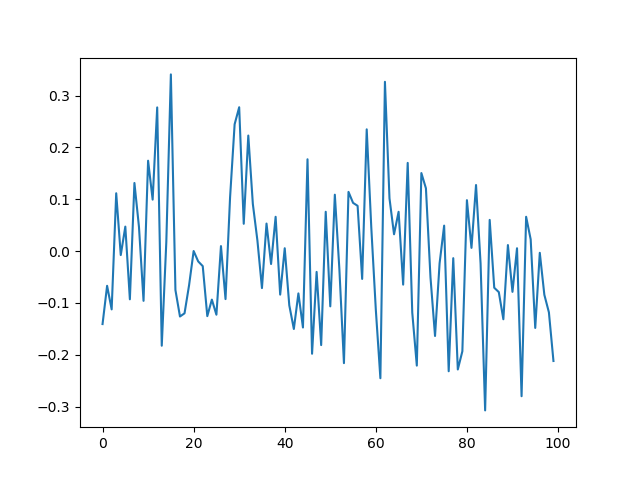

In [317]:
plt.plot(x,y[:100])
plt.show()